# Deep Reinforcement Learning

- Playing CartPole with the Actor-Critic Method
- Deep Deterministic Policy Gradient (DDPG)for the classic Inverted Pendulum control problem
- Deep Q-Learning for Atari Breakout
- Proximal Policy Optimization


# Playing CartPole with the Actor-Critic Method

This tutorial demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method to train an agent on the [Open AI Gym](https://gym.openai.com/) CartPole-V0 environment.
This is built on [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of reinforcement learning. 


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function. 

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**CartPole-v0**

In the [CartPole-v0 environment](https://gym.openai.com/envs/CartPole-v0), a pole is attached to a cart moving along a frictionless track. 
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart. 
A reward of +1 is given for every time step the pole remains upright.
An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.

![title](https://www.tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif)

<center>
  <figure>
    <image src="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic_files/output_TLd720SejKmf_0.gif">
    <figcaption>
      Trained actor-critic model in Cartpole-v0 environment
    </figcaption>
  </figure>
</center>


The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [4]:
!pip install gym
!pip install torch torchvision torchaudio

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 38.6 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [5]:
%%bash
# Install additional packages for visualization
# sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1

In [6]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from collections import deque
import random

# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.reset(seed=seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/opt/anaconda3/lib/python3.12/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


## Model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and critic value respectively. This tutorial uses model subclassing to define the model. 

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For Cartpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (0) and right (1) respectively.

Refer to [OpenAI Gym's CartPole-v0 wiki page](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) for more information.


In [7]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_size, num_actions)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.common(x)
        return self.actor(x), self.critic(x)

In [8]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
hidden_size = 128

model = ActorCritic(num_inputs, num_actions, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined actor-critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collecting training data

As in supervised learning, in order to train the actor-critic model, you need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

In [9]:
def env_step(action):
    state_info = env.step(action)
    if isinstance(state_info, tuple):
        state, reward, done, _ = state_info
    else:
        state, reward, done = state_info
    return torch.tensor(state, dtype=torch.float32), reward, done


In [10]:
def run_episode(model, max_steps):
    state_info = env.reset()
    state = torch.tensor(state_info[0] if isinstance(state_info, tuple) else state_info, dtype=torch.float32)
    log_probs, values, rewards = [], [], []

    for _ in range(max_steps):
        logits, value = model(state)
        action_probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(action_probs, 1).item()

        # Append log probabilities and values
        log_probs.append(torch.log(action_probs[action]).unsqueeze(0))
        values.append(value)

        state_info = env.step(action)
        if isinstance(state_info, tuple):
            state, reward, done, *_ = state_info
        else:
            state, reward, done = state_info

        state = torch.tensor(state, dtype=torch.float32)
        rewards.append(reward)

        if done:
            break

    return log_probs, values, rewards


### 2. Computing expected returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [11]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    discounted_sum = 0
    for reward in reversed(rewards):
        discounted_sum = reward + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = torch.tensor(returns, dtype=torch.float32)
    return (returns - returns.mean()) / (returns.std() + eps)

### 3. The actor-critic loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

The actor loss is based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [12]:
def compute_loss(log_probs, values, returns):
    advantage = returns - torch.cat(values)
    actor_loss = -torch.sum(torch.cat(log_probs) * advantage.detach())
    critic_loss = advantage.pow(2).mean()
    return actor_loss + critic_loss

### 4. Defining the training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This tutorial uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

In [13]:
def train_step(model, optimizer, gamma=0.99, max_steps_per_episode=1000):
    log_probs, values, rewards = run_episode(model, max_steps_per_episode)
    returns = compute_returns(rewards, gamma)

    loss = compute_loss(log_probs, values, returns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return sum(rewards)

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [14]:
min_episodes_criterion = 100
max_episodes = 10000
reward_threshold = 195
running_reward = 0

episode_rewards = deque(maxlen=min_episodes_criterion)

for i in range(max_episodes):
    episode_reward = train_step(model, optimizer)
    episode_rewards.append(episode_reward)
    running_reward = np.mean(episode_rewards)

    if running_reward > reward_threshold and i >= min_episodes_criterion:
        print(f'Solved at episode {i}: average reward: {running_reward:.2f}!')
        break

/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Solved at episode 155: average reward: 196.48!


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for OpenAI Gym to render the environment's images correctly in Colab.

In [15]:
!pip install pyvirtualdisplay xvfbwrapper
!pip install gym[classic_control]
!pip install tqdm

zsh:1: no matches found: gym[classic_control]


In [16]:
import torch
from PIL import Image

def render_episode(env, model, max_steps):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    state = torch.tensor(state, dtype=torch.float32)
    frames = []

    for _ in range(max_steps):
        frame = env.render()
        frames.append(Image.fromarray(frame))

        with torch.no_grad():
            logits = model(state.unsqueeze(0))[0]
        action = torch.argmax(torch.softmax(logits, dim=-1)).item()

        state, _, done, *_ = env.step(action)
        state = torch.tensor(state, dtype=torch.float32)
        if done:
            break

    return frames

env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = render_episode(env, model, max_steps=1000)
frames[0].save('cartpole.gif', save_all=True, append_images=frames[1:], loop=0, duration=40)


![title](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic_files/output_TLd720SejKmf_0.gif)


# Deep Deterministic Policy Gradient (DDPG)for the classic Inverted Pendulum control problem

## Introduction

Deep Deterministic Policy Gradient (DDPG) is a model-free off-policy algorithm for learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network). It uses Experience Replay and slow-learning target networks from DQN, and it is based on DPG, which can operate over continuous action spaces.

This tutorial closely follow this paper - Continuous control with deep reinforcement learning https://arxiv.org/pdf/1509.02971.pdf


## Problem

We are trying to solve the classic Inverted Pendulum control problem. In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions are continuous instead of being discrete. That is, instead of using two discrete actions like -1 or +1, we have to select from infinite actions ranging from -2 to +2.

## Quick theory
Just like the Actor-Critic method, we have two networks:

Actor - It proposes an action given a state.
Critic - It predicts if the action is good (positive value) or bad (negative value) given a state and an action.
DDPG uses two more techniques not present in the original DQN:

First, it uses two Target networks.

Why? Because it add stability to training. In short, we are learning from estimated targets and Target networks are updated slowly, hence keeping our estimated targets stable.

Conceptually, this is like saying, "I have an idea of how to play this well, I'm going to try it out for a bit until I find something better", as opposed to saying "I'm going to re-learn how to play this entire game after every move". See this StackOverflow answer.

Second, it uses Experience Replay.

We store list of tuples (state, action, reward, next_state), and instead of learning only from recent experience, we learn from sampling all of our experience accumulated so far.

Now, let's see how is it implemented.

We use OpenAIGym to create the environment. We will use the upper_bound parameter to scale our actions later.

In [17]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Pendulum-v1")
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("State space:", num_states)
print("Action space:", num_actions)

State space: 3
Action space: 1


To implement better exploration by the Actor network, we use noisy perturbations, specifically an Ornstein-Uhlenbeck process for generating noise, as described in the paper. It samples noise from a correlated normal distribution.

In [18]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * torch.sqrt(torch.tensor(self.dt)) * torch.randn_like(self.mean)
        )
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else torch.zeros_like(self.mean)

The Buffer class implements Experience Replay.

![title](https://i.imgur.com/mS6iGyJ.jpg)


**Critic loss** - Mean Squared Error of y - Q(s, a) where y is the expected return as seen by the Target network, and Q(s, a) is action value predicted by the Critic network. y is a moving target that the critic model tries to achieve; we make this target stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get the maximum predicted value as seen by the Critic, for a given state.

In [19]:
import numpy as np

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def sample(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = torch.tensor(self.state_buffer[batch_indices], dtype=torch.float32)
        action_batch = torch.tensor(self.action_buffer[batch_indices], dtype=torch.float32)
        reward_batch = torch.tensor(self.reward_buffer[batch_indices], dtype=torch.float32)
        next_state_batch = torch.tensor(self.next_state_buffer[batch_indices], dtype=torch.float32)

        return state_batch, action_batch, reward_batch, next_state_batch

Here we define the Actor and Critic networks. These are basic Dense models with ReLU activation.

Note: We need the initialization for last layer of the Actor to be between -0.003 and 0.003 as this prevents us from getting 1 or -1 output values in the initial stages, which would squash our gradients to zero, as we use the tanh activation.

def get_actor():

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, action_dim)
        self.action_bound = action_bound

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.out(x)) * self.action_bound
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [21]:
actor = Actor(num_states, num_actions, upper_bound)
critic = Critic(num_states, num_actions)

actor_target = Actor(num_states, num_actions, upper_bound)
critic_target = Critic(num_states, num_actions)

actor_target.load_state_dict(actor.state_dict())
critic_target.load_state_dict(critic.state_dict())

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.002)

Now we implement our main training loop, and iterate over episodes. We sample actions using policy() and train with learn() at each time step, along with updating the Target networks at a rate tau.



Training Progress:   1%|          | 1/100 [00:01<01:43,  1.05s/it]

Episode 0, Avg Reward: -7928.39304918569


Training Progress:   2%|▏         | 2/100 [00:02<01:47,  1.10s/it]

Episode 1, Avg Reward: -8035.720304903359


Training Progress:   3%|▎         | 3/100 [00:03<01:47,  1.11s/it]

Episode 2, Avg Reward: -6724.8359694201345


Training Progress:   4%|▍         | 4/100 [00:04<01:48,  1.13s/it]

Episode 3, Avg Reward: -5553.987657365215


Training Progress:   5%|▌         | 5/100 [00:05<01:48,  1.14s/it]

Episode 4, Avg Reward: -5850.602330894841


Training Progress:   6%|▌         | 6/100 [00:06<01:45,  1.12s/it]

Episode 5, Avg Reward: -5199.056263391598


Training Progress:   7%|▋         | 7/100 [00:07<01:44,  1.12s/it]

Episode 6, Avg Reward: -4680.25564028557


Training Progress:   8%|▊         | 8/100 [00:08<01:43,  1.13s/it]

Episode 7, Avg Reward: -4220.794811854083


Training Progress:   9%|▉         | 9/100 [00:10<01:42,  1.12s/it]

Episode 8, Avg Reward: -3756.4300920428204


Training Progress:  10%|█         | 10/100 [00:11<01:41,  1.13s/it]

Episode 9, Avg Reward: -3393.1288136561066


Training Progress:  11%|█         | 11/100 [00:12<01:40,  1.13s/it]

Episode 10, Avg Reward: -3096.50481498606


Training Progress:  12%|█▏        | 12/100 [00:13<01:39,  1.13s/it]

Episode 11, Avg Reward: -2849.1355686091597


Training Progress:  13%|█▎        | 13/100 [00:14<01:37,  1.13s/it]

Episode 12, Avg Reward: -2649.4174341704947


Training Progress:  14%|█▍        | 14/100 [00:15<01:36,  1.12s/it]

Episode 13, Avg Reward: -2469.2121566231485


Training Progress:  15%|█▌        | 15/100 [00:16<01:35,  1.12s/it]

Episode 14, Avg Reward: -2328.4950018078957


Training Progress:  16%|█▌        | 16/100 [00:17<01:34,  1.12s/it]

Episode 15, Avg Reward: -2191.436879246178


Training Progress:  17%|█▋        | 17/100 [00:19<01:34,  1.13s/it]

Episode 16, Avg Reward: -2069.726357174769


Training Progress:  18%|█▊        | 18/100 [00:20<01:32,  1.13s/it]

Episode 17, Avg Reward: -1962.6947384066652


Training Progress:  19%|█▉        | 19/100 [00:21<01:31,  1.13s/it]

Episode 18, Avg Reward: -1867.5306238497114


Training Progress:  20%|██        | 20/100 [00:22<01:30,  1.13s/it]

Episode 19, Avg Reward: -1793.3796281528425


Training Progress:  21%|██        | 21/100 [00:23<01:29,  1.13s/it]

Episode 20, Avg Reward: -1720.5123535308517


Training Progress:  22%|██▏       | 22/100 [00:24<01:28,  1.13s/it]

Episode 21, Avg Reward: -1643.8754120521598


Training Progress:  23%|██▎       | 23/100 [00:25<01:27,  1.13s/it]

Episode 22, Avg Reward: -1583.8444952291811


Training Progress:  24%|██▍       | 24/100 [00:27<01:26,  1.14s/it]

Episode 23, Avg Reward: -1557.841254465067


Training Progress:  25%|██▌       | 25/100 [00:28<01:25,  1.14s/it]

Episode 24, Avg Reward: -1496.0453007354333


Training Progress:  26%|██▌       | 26/100 [00:29<01:24,  1.14s/it]

Episode 25, Avg Reward: -1452.7319183933525


Training Progress:  27%|██▋       | 27/100 [00:30<01:23,  1.15s/it]

Episode 26, Avg Reward: -1408.5879104361088


Training Progress:  28%|██▊       | 28/100 [00:31<01:23,  1.16s/it]

Episode 27, Avg Reward: -1380.9637797066648


Training Progress:  29%|██▉       | 29/100 [00:32<01:24,  1.19s/it]

Episode 28, Avg Reward: -1341.785353821872


Training Progress:  30%|███       | 30/100 [00:34<01:24,  1.21s/it]

Episode 29, Avg Reward: -1301.2565247163916


Training Progress:  31%|███       | 31/100 [00:35<01:26,  1.26s/it]

Episode 30, Avg Reward: -1267.1140659584923


Training Progress:  32%|███▏      | 32/100 [00:36<01:23,  1.23s/it]

Episode 31, Avg Reward: -1231.4227737857636


Training Progress:  33%|███▎      | 33/100 [00:37<01:22,  1.22s/it]

Episode 32, Avg Reward: -1194.3569798536869


Training Progress:  34%|███▍      | 34/100 [00:39<01:19,  1.20s/it]

Episode 33, Avg Reward: -1163.1105505823284


Training Progress:  35%|███▌      | 35/100 [00:40<01:16,  1.18s/it]

Episode 34, Avg Reward: -1130.138285287966


Training Progress:  36%|███▌      | 36/100 [00:41<01:14,  1.17s/it]

Episode 35, Avg Reward: -1102.4434915480986


Training Progress:  37%|███▋      | 37/100 [00:42<01:12,  1.16s/it]

Episode 36, Avg Reward: -1073.0908178989575


Training Progress:  38%|███▊      | 38/100 [00:43<01:11,  1.15s/it]

Episode 37, Avg Reward: -1048.2742192405155


Training Progress:  39%|███▉      | 39/100 [00:44<01:10,  1.16s/it]

Episode 38, Avg Reward: -1028.2305378564236


Training Progress:  40%|████      | 40/100 [00:46<01:11,  1.19s/it]

Episode 39, Avg Reward: -1005.8312310005192


Training Progress:  41%|████      | 41/100 [00:47<01:11,  1.21s/it]

Episode 40, Avg Reward: -810.8535567719118


Training Progress:  42%|████▏     | 42/100 [00:48<01:10,  1.21s/it]

Episode 41, Avg Reward: -617.7397940327189


Training Progress:  43%|████▎     | 43/100 [00:49<01:08,  1.20s/it]

Episode 42, Avg Reward: -518.7217643417325


Training Progress:  44%|████▍     | 44/100 [00:50<01:06,  1.19s/it]

Episode 43, Avg Reward: -487.29075113425245


Training Progress:  45%|████▌     | 45/100 [00:52<01:07,  1.23s/it]

Episode 44, Avg Reward: -315.0948287293013


Training Progress:  46%|████▌     | 46/100 [00:53<01:05,  1.21s/it]

Episode 45, Avg Reward: -266.70207699530795


Training Progress:  47%|████▋     | 47/100 [00:54<01:03,  1.20s/it]

Episode 46, Avg Reward: -230.7574299117342


Training Progress:  48%|████▊     | 48/100 [00:55<01:03,  1.22s/it]

Episode 47, Avg Reward: -208.87779857443925


Training Progress:  49%|████▉     | 49/100 [00:57<01:02,  1.23s/it]

Episode 48, Avg Reward: -215.82829322365734


Training Progress:  50%|█████     | 50/100 [00:58<01:01,  1.24s/it]

Episode 49, Avg Reward: -216.23279405956356


Training Progress:  51%|█████     | 51/100 [00:59<01:01,  1.25s/it]

Episode 50, Avg Reward: -216.39668536033992


Training Progress:  52%|█████▏    | 52/100 [01:00<01:01,  1.28s/it]

Episode 51, Avg Reward: -213.28349701207284


Training Progress:  53%|█████▎    | 53/100 [01:02<01:01,  1.30s/it]

Episode 52, Avg Reward: -210.49984280137514


Training Progress:  54%|█████▍    | 54/100 [01:03<01:00,  1.31s/it]

Episode 53, Avg Reward: -217.0843729701588


Training Progress:  55%|█████▌    | 55/100 [01:04<00:57,  1.28s/it]

Episode 54, Avg Reward: -211.53076497524717


Training Progress:  56%|█████▌    | 56/100 [01:06<00:55,  1.25s/it]

Episode 55, Avg Reward: -214.58575604454896


Training Progress:  57%|█████▋    | 57/100 [01:07<00:52,  1.23s/it]

Episode 56, Avg Reward: -214.79373493161066


Training Progress:  58%|█████▊    | 58/100 [01:08<00:51,  1.22s/it]

Episode 57, Avg Reward: -214.57786104616426


Training Progress:  59%|█████▉    | 59/100 [01:09<00:50,  1.23s/it]

Episode 58, Avg Reward: -220.27838513742887


Training Progress:  60%|██████    | 60/100 [01:10<00:48,  1.22s/it]

Episode 59, Avg Reward: -216.8783489353504


Training Progress:  61%|██████    | 61/100 [01:12<00:47,  1.22s/it]

Episode 60, Avg Reward: -213.72383230942108


Training Progress:  62%|██████▏   | 62/100 [01:13<00:46,  1.22s/it]

Episode 61, Avg Reward: -288.0456287468555


Training Progress:  63%|██████▎   | 63/100 [01:14<00:45,  1.23s/it]

Episode 62, Avg Reward: -287.61744160751243


Training Progress:  64%|██████▍   | 64/100 [01:15<00:44,  1.25s/it]

Episode 63, Avg Reward: -266.7321286691813


Training Progress:  65%|██████▌   | 65/100 [01:17<00:43,  1.24s/it]

Episode 64, Avg Reward: -266.53258296016423


Training Progress:  66%|██████▌   | 66/100 [01:18<00:42,  1.24s/it]

Episode 65, Avg Reward: -257.39353385268276


Training Progress:  67%|██████▋   | 67/100 [01:19<00:40,  1.23s/it]

Episode 66, Avg Reward: -257.8912700530236


Training Progress:  68%|██████▊   | 68/100 [01:20<00:39,  1.22s/it]

Episode 67, Avg Reward: -275.82145875986174


Training Progress:  69%|██████▉   | 69/100 [01:21<00:37,  1.22s/it]

Episode 68, Avg Reward: -275.76859043084676


Training Progress:  70%|███████   | 70/100 [01:23<00:36,  1.22s/it]

Episode 69, Avg Reward: -278.41476544223644


Training Progress:  71%|███████   | 71/100 [01:24<00:35,  1.22s/it]

Episode 70, Avg Reward: -275.4764084768566


Training Progress:  72%|███████▏  | 72/100 [01:25<00:34,  1.22s/it]

Episode 71, Avg Reward: -278.34388714650606


Training Progress:  73%|███████▎  | 73/100 [01:26<00:33,  1.22s/it]

Episode 72, Avg Reward: -281.49308432139344


Training Progress:  74%|███████▍  | 74/100 [01:28<00:31,  1.22s/it]

Episode 73, Avg Reward: -281.5562769391919


Training Progress:  75%|███████▌  | 75/100 [01:29<00:30,  1.22s/it]

Episode 74, Avg Reward: -290.90765967285023


Training Progress:  76%|███████▌  | 76/100 [01:30<00:29,  1.22s/it]

Episode 75, Avg Reward: -290.7560765636028


Training Progress:  77%|███████▋  | 77/100 [01:31<00:28,  1.22s/it]

Episode 76, Avg Reward: -296.728950229162


Training Progress:  78%|███████▊  | 78/100 [01:32<00:26,  1.22s/it]

Episode 77, Avg Reward: -296.5225197135218


Training Progress:  79%|███████▉  | 79/100 [01:34<00:25,  1.23s/it]

Episode 78, Avg Reward: -290.2766897185508


Training Progress:  80%|████████  | 80/100 [01:35<00:24,  1.23s/it]

Episode 79, Avg Reward: -287.37003908037406


Training Progress:  81%|████████  | 81/100 [01:36<00:23,  1.23s/it]

Episode 80, Avg Reward: -287.654470390893


Training Progress:  82%|████████▏ | 82/100 [01:37<00:22,  1.23s/it]

Episode 81, Avg Reward: -286.74912023598336


Training Progress:  83%|████████▎ | 83/100 [01:39<00:20,  1.22s/it]

Episode 82, Avg Reward: -286.760510783534


Training Progress:  84%|████████▍ | 84/100 [01:40<00:19,  1.23s/it]

Episode 83, Avg Reward: -270.6036170219472


Training Progress:  85%|████████▌ | 85/100 [01:41<00:18,  1.22s/it]

Episode 84, Avg Reward: -270.27836102887414


Training Progress:  86%|████████▌ | 86/100 [01:42<00:17,  1.22s/it]

Episode 85, Avg Reward: -273.2767095343299


Training Progress:  87%|████████▋ | 87/100 [01:43<00:15,  1.22s/it]

Episode 86, Avg Reward: -276.43466453476566


Training Progress:  88%|████████▊ | 88/100 [01:45<00:14,  1.22s/it]

Episode 87, Avg Reward: -276.6098564463129


Training Progress:  89%|████████▉ | 89/100 [01:46<00:14,  1.28s/it]

Episode 88, Avg Reward: -272.0005896614095


Training Progress:  90%|█████████ | 90/100 [01:48<00:13,  1.34s/it]

Episode 89, Avg Reward: -274.4214071475809


Training Progress:  91%|█████████ | 91/100 [01:49<00:12,  1.37s/it]

Episode 90, Avg Reward: -277.29944241200224


Training Progress:  92%|█████████▏| 92/100 [01:50<00:11,  1.39s/it]

Episode 91, Avg Reward: -280.1314017746589


Training Progress:  93%|█████████▎| 93/100 [01:52<00:09,  1.41s/it]

Episode 92, Avg Reward: -279.7959698197057


Training Progress:  94%|█████████▍| 94/100 [01:53<00:08,  1.43s/it]

Episode 93, Avg Reward: -270.0744681000527


Training Progress:  95%|█████████▌| 95/100 [01:55<00:07,  1.44s/it]

Episode 94, Avg Reward: -272.9337366456222


Training Progress:  96%|█████████▌| 96/100 [01:56<00:05,  1.45s/it]

Episode 95, Avg Reward: -275.99312842983466


Training Progress:  97%|█████████▋| 97/100 [01:58<00:04,  1.47s/it]

Episode 96, Avg Reward: -278.72502990525794


Training Progress:  98%|█████████▊| 98/100 [01:59<00:02,  1.48s/it]

Episode 97, Avg Reward: -278.45082766447706


Training Progress:  99%|█████████▉| 99/100 [02:01<00:01,  1.49s/it]

Episode 98, Avg Reward: -272.0729234089743


Training Progress: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Episode 99, Avg Reward: -271.87327773138577


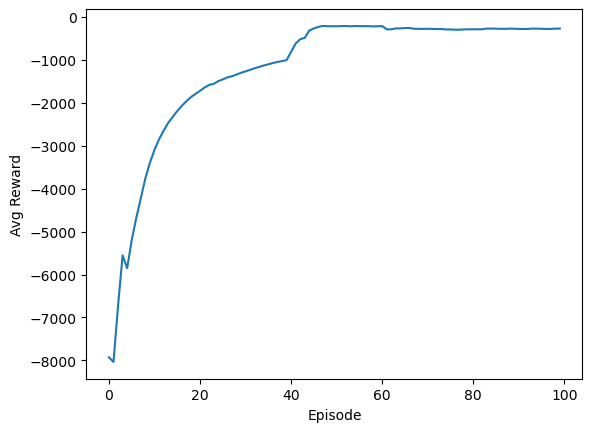

In [22]:
from tqdm import tqdm  # Import the tqdm library for progress display

ep_reward_list = []
avg_reward_list = []

buffer = Buffer(50000, 64)
ou_noise = OUActionNoise(mean=torch.zeros(1), std_deviation=0.2 * torch.ones(1))

def policy(state, noise):
    # Use the actor network to predict actions with added noise for exploration
    with torch.no_grad():
        action = actor(state) + noise()
    return action.clamp(lower_bound, upper_bound)

# Set a maximum step limit per episode to prevent infinite loops
MAX_STEPS_PER_EPISODE = 1000

# Wrap the main loop with tqdm for progress tracking
for ep in tqdm(range(100), desc="Training Progress"):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]  # Unpack if the environment returns a tuple
    state = torch.tensor(state, dtype=torch.float32)
    episodic_reward = 0

    for step in range(MAX_STEPS_PER_EPISODE):  # Add a step limit
        # Select action using the policy and apply it to the environment
        action = policy(state.unsqueeze(0), ou_noise).squeeze(0).numpy()
        next_state, reward, done, *_ = env.step(action)

        # Record the transition in the replay buffer
        buffer.record((state.numpy(), action, reward, next_state))
        state = torch.tensor(next_state, dtype=torch.float32)

        # Perform training when there are enough samples in the buffer
        if buffer.buffer_counter > buffer.batch_size:
            state_batch, action_batch, reward_batch, next_state_batch = buffer.sample()

            # Update Critic network
            target_actions = actor_target(next_state_batch)
            y = reward_batch + 0.99 * critic_target(next_state_batch, target_actions)
            critic_loss = F.mse_loss(critic(state_batch, action_batch), y.detach())

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update Actor network
            actor_loss = -critic(state_batch, actor(state_batch)).mean()

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Update target networks using soft updates
            with torch.no_grad():
                for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                    target_param.data.copy_(0.005 * param.data + 0.995 * target_param.data)

                for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                    target_param.data.copy_(0.005 * param.data + 0.995 * target_param.data)

        episodic_reward += reward
        if done:  # Exit the loop if the episode ends
            break

    # Append the episodic reward and calculate the moving average
    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    # Print the average reward for the current episode
    tqdm.write(f"Episode {ep}, Avg Reward: {avg_reward}")

# Plot the average reward trend
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.show()


If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, tau values, and architectures for the Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other problems.

Another great environment to try this on is LunarLandingContinuous-v2, but it will take more episodes to obtain good results.

before training:
![title](https://i.imgur.com/ox6b9rC.giff)

after training:
![title](https://i.imgur.com/eEH8Cz6.gif)
